In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.16.1


In [2]:
# !pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 4412s 2us/step


In [7]:
FEATURES = 28

In [8]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [9]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


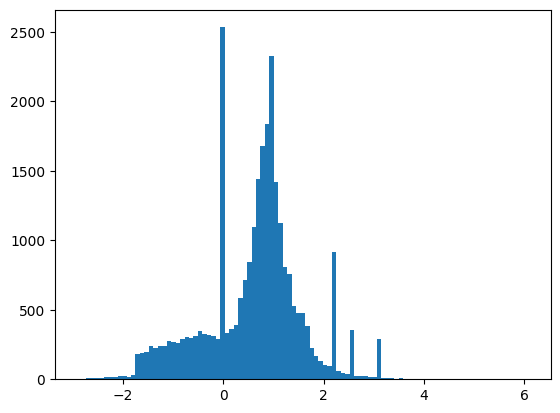

In [11]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [12]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### 과대적합 예제

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

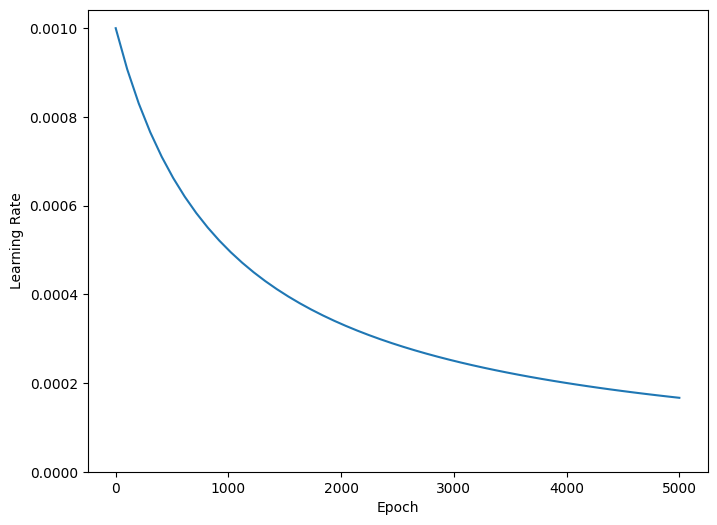

In [17]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [18]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [20]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

c:\Users\GIT\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4935,  binary_crossentropy:0.7221,  loss:0.7221,  val_accuracy:0.4860,  val_binary_crossentropy:0.4715,  val_loss:0.4715,  
.....

c:\Users\GIT\AppData\Local\anaconda3\envs\tf\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


...............................................................................................
Epoch: 100, accuracy:0.5976,  binary_crossentropy:0.6243,  loss:0.6243,  val_accuracy:0.6000,  val_binary_crossentropy:0.4155,  val_loss:0.4155,  
....................................................................................................
Epoch: 200, accuracy:0.6158,  binary_crossentropy:0.6142,  loss:0.6142,  val_accuracy:0.6010,  val_binary_crossentropy:0.4127,  val_loss:0.4127,  
....................................................................................................
Epoch: 300, accuracy:0.6284,  binary_crossentropy:0.6071,  loss:0.6071,  val_accuracy:0.6160,  val_binary_crossentropy:0.4090,  val_loss:0.4090,  
....................................................................................................
Epoch: 400, accuracy:0.6418,  binary_crossentropy:0.6014,  loss:0.6014,  val_accuracy:0.6250,  val_binary_crossentropy:0.4072,  val_loss:0.4072,  
.............

(0.5, 0.7)

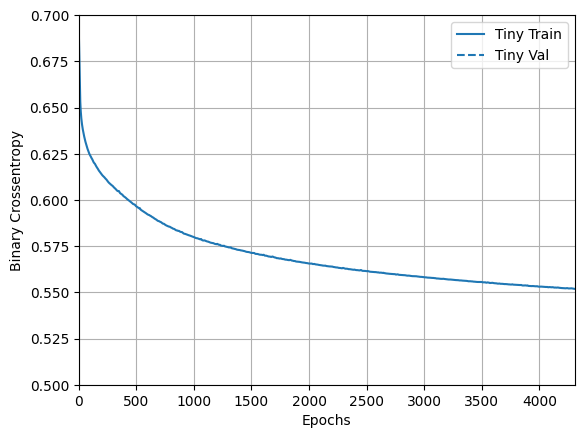

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [24]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4865,  binary_crossentropy:0.7567,  loss:0.7567,  val_accuracy:0.4880,  val_binary_crossentropy:0.4805,  val_loss:0.4805,  
....................................................................................................
Epoch: 100, accuracy:0.6344,  binary_crossentropy:0.6082,  loss:0.6082,  val_accuracy:0.6200,  val_binary_crossentropy:0.4018,  val_loss:0.4018,  
....................................................................................................
Epoch: 200, accuracy:0.6754,  binary_crossentropy:0.5844,  loss:0.5844,  val_accuracy:0.6660,  val_binary_crossentropy:0.3936,  val_loss:0.3936,  
....................................................................................................
Epoch: 300, accuracy:0.6803,  binary_crossentropy:0.5770,  loss:0.5770,  val_accuracy:0.6330,  val_binary_crossentropy:0.3970,  val_loss:0.3970,  
....................................................................................................
Epoch: 40

In [26]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [27]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5035,  binary_crossentropy:0.7177,  loss:0.7177,  val_accuracy:0.4610,  val_binary_crossentropy:0.4572,  val_loss:0.4572,  
....................................................................................................
Epoch: 100, accuracy:0.7193,  binary_crossentropy:0.5270,  loss:0.5270,  val_accuracy:0.6570,  val_binary_crossentropy:0.4063,  val_loss:0.4063,  
....................................................................................................
Epoch: 200, accuracy:0.7848,  binary_crossentropy:0.4311,  loss:0.4311,  val_accuracy:0.6670,  val_binary_crossentropy:0.4675,  val_loss:0.4675,  
...............................................

In [28]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [29]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5092,  binary_crossentropy:0.7646,  loss:0.7646,  val_accuracy:0.5500,  val_binary_crossentropy:0.4564,  val_loss:0.4564,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0021,  loss:0.0021,  val_accuracy:0.6520,  val_binary_crossentropy:1.1691,  val_loss:1.1691,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6620,  val_binary_crossentropy:1.5716,  val_loss:1.5716,  
.........................

Text(0.5, 0, 'Epochs [Log Scale]')

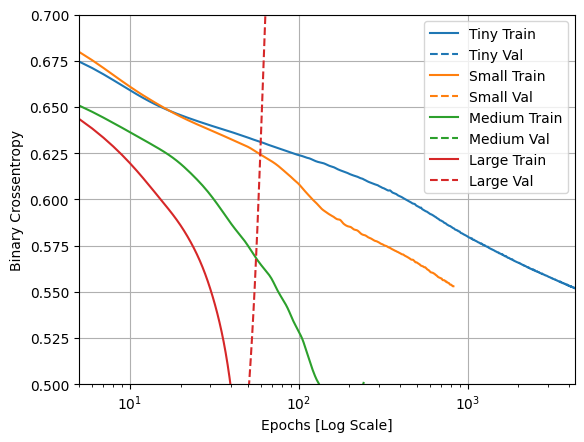

In [30]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [31]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [33]:
tensorboard dev upload --logdir  {logdir}/sizes

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-04-04 10:11:15.354273: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 10:11:16.679210: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.

In [34]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/GIT/AppData/Local/Temp/tmpmi9kgiw1/tensorboard_logs/regularizers/Tiny')

In [35]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [36]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5056,  binary_crossentropy:0.7862,  loss:2.2933,  val_accuracy:0.5210,  val_binary_crossentropy:0.4528,  val_loss:1.4009,  
....................................................................................................
Epoch: 100, accuracy:0.6525,  binary_crossentropy:0.6042,  loss:0.6276,  val_accuracy:0.6680,  val_binary_crossentropy:0.3937,  val_loss:0.4090,  
....................................................................................................
Epoch: 200, accuracy:0.6664,  binary_crossentropy:0.5854,  loss:0.6087,  val_accuracy:0.6930,  val_binary_crossentropy:0.3899,  val_loss:0.4057,  
....................................................................................................
Epoch: 300, accuracy:0.6854,  binary_crossentropy:0.5714,  loss:0.5953,  val_accuracy:0.6880,  val_binary_crossentropy:0.3824,  val_loss:0.3983,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

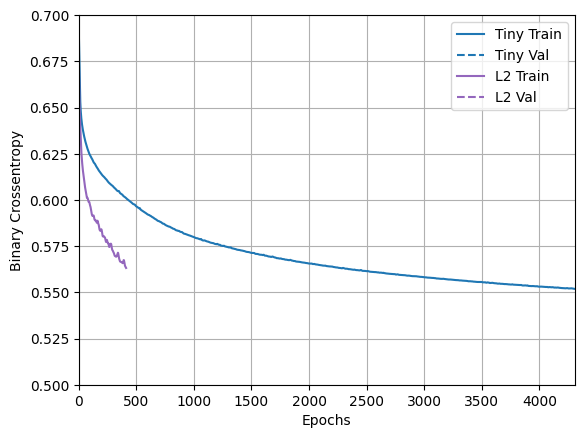

In [37]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [38]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [39]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5094,  binary_crossentropy:0.7806,  loss:0.7806,  val_accuracy:0.5460,  val_binary_crossentropy:0.4466,  val_loss:0.4466,  
....................................................................................................
Epoch: 100, accuracy:0.6561,  binary_crossentropy:0.5950,  loss:0.5950,  val_accuracy:0.6810,  val_binary_crossentropy:0.3835,  val_loss:0.3835,  
....................................................................................................
Epoch: 200, accuracy:0.6921,  binary_crossentropy:0.5540,  loss:0.5540,  val_accuracy:0.6860,  val_binary_crossentropy:0.3875,  val_loss:0.3875,  
....................................................................................................
Epoch: 300, accuracy:0.7236,  binary_crossentropy:0.5065,  loss:0.5065,  val_accuracy:0.6740,  val_binary_crossentropy:0.4031,  val_loss:0.4031,  
.......

(0.5, 0.7)

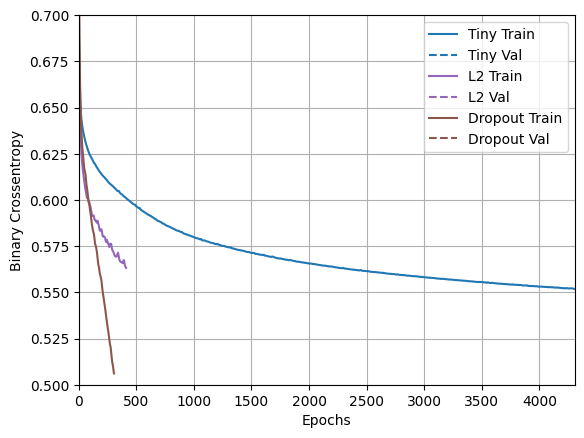

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [41]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5012,  binary_crossentropy:0.7969,  loss:0.9553,  val_accuracy:0.5050,  val_binary_crossentropy:0.4495,  val_loss:0.5547,  
....................................................................................................
Epoch: 100, accuracy:0.6523,  binary_crossentropy:0.6047,  loss:0.6344,  val_accuracy:0.6700,  val_binary_crossentropy:0.3867,  val_loss:0.4064,  
....................................................................................................
Epoch: 200, accuracy:0.6654,  binary_crossentropy:0.5868,  loss:0.6134,  val_accuracy:0.6960,  val_binary_crossentropy:0.3773,  val_loss:0.3951,  
....................................................................................................
Epoch: 300, accuracy:0.6739,  binary_crossentropy:0.5823,  loss:0.6113,  val_accuracy:0.6700,  val_binary_crossentropy:0.3760,  val_loss:0.3954,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

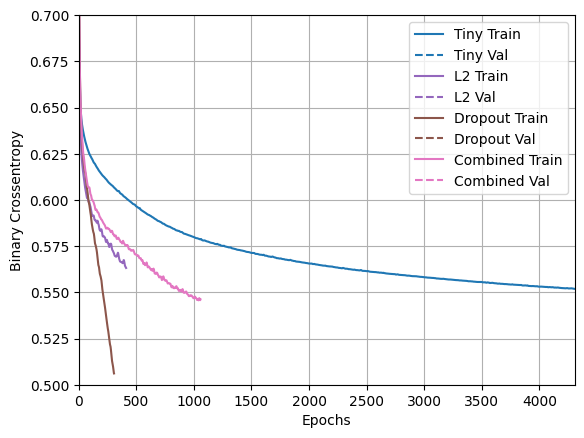

In [42]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [43]:
%tensorboard --logdir {logdir}/regularizers

In [44]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

In [45]:
tensorboard dev upload --logdir  {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-04-04 10:20:29.753616: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 10:20:31.072680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.